In [1]:
from typing import List

import torch
from torch import nn, autograd, Tensor
from torch.nn import functional as F


def calc_grad(y, x) -> Tensor:
    grad = autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
    )[0]
    return grad


class Pinn(nn.Module):
    """
    `forward`: returns a tensor of shape (D, 3), where D is the number of
    data points, and the 2nd dim. is the predicted values of p, u, v.
    """

    def __init__(self, hidden_dims: List[int]):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.ffn_layers = []
        input_dim = 3
        for hidden_dim in hidden_dims:
            self.ffn_layers.append(nn.Linear(input_dim, hidden_dim))
            self.ffn_layers.append(nn.Tanh())
            input_dim = hidden_dim
        self.ffn_layers.append(nn.Linear(input_dim, 2))
        self.ffn = nn.Sequential(*self.ffn_layers)

        self.lambda1 = nn.Parameter(torch.tensor(0.0))
        self.lambda2 = nn.Parameter(torch.tensor(0.0))

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(
        self,
        x: Tensor,
        y: Tensor,
        t: Tensor,
        p: Tensor = None,
        u: Tensor = None,
        v: Tensor = None,
    ):
        """
        All shapes are (b,)

        inputs: x, y, t
        labels: p, u, v
        """
        inputs = torch.stack([x, y, t], dim=1)
        hidden_output = self.ffn(inputs)
        psi = hidden_output[:, 0]
        p_pred = hidden_output[:, 1]
        u_pred = calc_grad(psi, y)
        v_pred = -calc_grad(psi, x)

        preds = torch.stack([p_pred, u_pred, v_pred], dim=1)
        u_t = calc_grad(u_pred, t)
        u_x = calc_grad(u_pred, x)
        u_y = calc_grad(u_pred, y)
        u_xx = calc_grad(u_x, x)
        u_yy = calc_grad(u_y, y)

        v_t = calc_grad(v_pred, t)
        v_x = calc_grad(v_pred, x)
        v_y = calc_grad(v_pred, y)
        v_xx = calc_grad(v_x, x)
        v_yy = calc_grad(v_y, y)

        p_x = calc_grad(p_pred, x)
        p_y = calc_grad(p_pred, y)

        f_u = (
            u_t
            + self.lambda1 * (u_pred * u_x + v_pred * u_y)
            + p_x
            - self.lambda2 * (u_xx + u_yy)
        )
        f_v = (
            v_t
            + self.lambda1 * (u_pred * v_x + v_pred * v_y)
            + p_y
            - self.lambda2 * (v_xx + v_yy)
        )
        loss = self.loss_fn(u, v, u_pred, v_pred, f_u, f_v)
        return {
            "preds": preds,
            "loss": loss,
        }

    def loss_fn(self, u, v, u_pred, v_pred, f_u_pred, f_v_pred):
        """
        u: (b, 1)
        v: (b, 1)
        p: (b, 1)
        """
        loss = (
            F.mse_loss(u, u_pred, reduction="sum")
            + F.mse_loss(v, v_pred, reduction="sum")
            + F.mse_loss(f_u_pred, torch.zeros_like(f_u_pred), reduction="sum")
            + F.mse_loss(f_v_pred, torch.zeros_like(f_v_pred), reduction="sum")
        )
        return loss

In [2]:
import json
from pathlib import Path
from typing import List, Tuple
import random
from time import time
import scipy

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler

class PinnDataset(Dataset):
    def __init__(self, data: List[List[float]]):
        self.data = data
        self.examples = torch.tensor(
            data, dtype=torch.float32, requires_grad=True
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        headers = ["t", "x", "y", "p", "u", "v"]
        return {key: self.examples[idx, i] for i, key in enumerate(headers)}


def load_jsonl(path, skip_first_lines: int = 0):
    with open(path, "r") as f:
        for _ in range(skip_first_lines):
            next(f)
        return [json.loads(line) for line in f]


def dump_json(path, data):
    with open(path, "w") as f:
        json.dump(data, f, indent=4)


def get_dataset(data_path: Path) -> Tuple[PinnDataset, PinnDataset]:
    data = load_jsonl(data_path, skip_first_lines=1)
    random.shuffle(data)

    # It's weird that the test data is a subset of train data, but
    # that's what the original paper does.
    split_idx = int(len(data) * 0.9)
    train_data = data
    test_data = data[split_idx:]

    # train_data = train_data[:10000]
    # train_data = train_data[:1000]

    train_data = PinnDataset(train_data)
    test_data = PinnDataset(test_data)
    return train_data, test_data

def get_orig_dataset():
    path = Path("/data/home/jmerigot/PINN/PINN_data/cylinder_nektar_wake.mat")
    data = scipy.io.loadmat(path)
    X_star = data["X_star"]  # N x 2
    x = X_star[:, 0:1]
    y = X_star[:, 1:2]

    U_star = data["U_star"]  # N x 2 x T
    P_star = data["p_star"]  # N x T
    t_star = data["t"]  # T x 1
    X_star = data["X_star"]  # N x 2

    N = X_star.shape[0]
    T = t_star.shape[0]

    # Rearrange Data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T

    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star  # N x T

    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1

    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1

    min_x = np.min(x)
    max_x = np.max(x)

    NOISE_SCALE = 0.1
    u += NOISE_SCALE * np.std(u) * np.random.randn(*u.shape)
    v += NOISE_SCALE * np.std(v) * np.random.randn(*v.shape)

    train_data = np.hstack((t, x, y, p, u, v))
    # Randomly sample 1000 points as test data
    idx = np.random.choice(train_data.shape[0], 1000, replace=False)
    test_data = train_data[idx, :]
    train_data = PinnDataset(train_data)
    test_data = PinnDataset(test_data)
    return train_data, test_data, min_x, max_x

In [3]:
torch.random.manual_seed(0)
random.seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model
hidden_dims = [20] * 8
model = Pinn(hidden_dims=hidden_dims)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

# Data
#data_path = Path("E:/donny/code/family/00/data/data.jsonl")
#train_data, test_data = get_dataset(data_path)
train_data, test_data, min_x, max_x = get_orig_dataset()

sample = train_data[100]
print(sample)

Using device: cuda
Number of parameters: 3064
{'t': tensor(10., grad_fn=<SelectBackward0>), 'x': tensor(1., grad_fn=<SelectBackward0>), 'y': tensor(-2., grad_fn=<SelectBackward0>), 'p': tensor(-0.0834, grad_fn=<SelectBackward0>), 'u': tensor(1.2054, grad_fn=<SelectBackward0>), 'v': tensor(-0.0099, grad_fn=<SelectBackward0>)}


In [4]:
class Trainer:
    '''Trainer for convenient training and testing'''
    def __init__(self, model: Pinn):
        self.model = model

        # Hyperparameters
        self.lr = 1e-3
        self.lr_step = 1  # Unit is epoch
        self.lr_gamma = 0.5
        self.num_epochs = 40
        self.batch_size = 4096
        self.log_interval = 1
        self.samples_per_ep = 20000

        self.output_dir = Path(
            "result_NavierStokes",
            f"pinn-bs{self.batch_size}-lr{self.lr}-lrstep{self.lr_step}"
            f"-lrgamma{self.lr_gamma}-epoch{self.num_epochs}",
        )

        print(f"Output dir: {self.output_dir}")
        self.output_dir.mkdir(parents=True, exist_ok=True)
        args = {}
        for attr in ["lr", "lr_step", "lr_gamma", "num_epochs", "batch_size"]:
            args[attr] = getattr(self, attr)
        dump_json(self.output_dir / "args.json", args)

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.lr_scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=100, gamma=0.5
        )
        
        self.loss_history = []

    def get_last_ckpt_dir(self) -> Path:
        ckpts = list(self.output_dir.glob("ckpt-*"))
        if len(ckpts) == 0:
            return None
        return sorted(ckpts)[-1]

    def train(self, train_data: PinnDataset):
        model = self.model
        device = self.device

        sampler = RandomSampler(
            train_data,
            replacement=True,
            num_samples=self.samples_per_ep,
        )
        train_loader = DataLoader(
            train_data, batch_size=self.batch_size, sampler=sampler
        )

        print("====== Training ======")
        print(f"# epochs: {self.num_epochs}")
        print(f"# examples: {len(train_data)}")
        print(f"# samples used per epoch: {self.samples_per_ep}")
        print(f"batch size: {self.batch_size}")
        print(f"# steps: {len(train_loader)}")
        loss_history = []
        model.train()
        model.to(device)

        # Resume
        last_ckpt_dir = self.get_last_ckpt_dir()
        if last_ckpt_dir is not None:
            print(f"Resuming from {last_ckpt_dir}")
            model.load_state_dict(torch.load(last_ckpt_dir / "ckpt.pt"))
            self.optimizer.load_state_dict(
                torch.load(last_ckpt_dir / "optimizer.pt")
            )
            self.lr_scheduler.load_state_dict(
                torch.load(last_ckpt_dir / "lr_scheduler.pt")
            )
            ep = int(last_ckpt_dir.name.split("-")[-1]) + 1
        else:
            ep = 0

        train_start_time = time()
        while ep < self.num_epochs:
            print(f"====== Epoch {ep} ======")
            for step, batch in enumerate(train_loader):
                inputs = {k: t.to(device) for k, t in batch.items()}

                # Forward
                outputs = model(**inputs)
                loss = outputs["loss"]
                loss_history.append(loss.item())

                # Backward
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                if step % self.log_interval == 0:
                    print(
                        {
                            "step": step,
                            "loss": round(loss.item(), 6),
                            "lr": round(
                                self.optimizer.param_groups[0]["lr"], 4
                            ),
                            "lambda1": round(self.model.lambda1.item(), 4),
                            "lambda2": round(self.model.lambda2.item(), 4),
                            "time": round(time() - train_start_time, 1),
                        }
                    )
            self.lr_scheduler.step()
            self.checkpoint(ep)
            print(f"====== Epoch {ep} done ======")
            ep += 1
        print("====== Training done ======")

    def checkpoint(self, ep: int):
        """
        Dump checkpoint (model, optimizer, lr_scheduler) to "ckpt-{ep}" in
        the `output_dir`,

        and dump `self.loss_history` to "loss_history.json" in the
        `ckpt_dir`, and clear `self.loss_history`.
        """
        # Evaluate and save
        ckpt_dir = self.output_dir / f"ckpt-{ep}"
        ckpt_dir.mkdir(parents=True, exist_ok=True)
        print(f"Checkpointing to {ckpt_dir}")
        torch.save(self.model.state_dict(), ckpt_dir / "ckpt.pt")
        torch.save(self.optimizer.state_dict(), ckpt_dir / "optimizer.pt")
        torch.save(
            self.lr_scheduler.state_dict(), ckpt_dir / "lr_scheduler.pt"
        )
        dump_json(ckpt_dir / "loss_history.json", self.loss_history)
        self.loss_history = []

    def predict(self, test_data: PinnDataset) -> dict:
        batch_size = self.batch_size * 32
        test_loader = DataLoader(
            test_data, batch_size=batch_size, shuffle=False
        )
        print("====== Testing ======")
        print(f"# examples: {len(test_data)}")
        print(f"batch size: {batch_size}")
        print(f"# steps: {len(test_loader)}")

        self.model.to(self.device)
        self.model.train()  # We need gradient to predict
        all_preds = []
        all_losses = []
        for step, batch in enumerate(test_loader):
            batch = {key: t.to(self.device) for key, t in batch.items()}
            outputs = self.model(**batch)
            all_losses.append(outputs["loss"].item())
            all_preds.append(outputs["preds"])
        print("====== Testing done ======")
        all_preds = torch.cat(all_preds, 0)
        loss = sum(all_losses) / len(all_losses)
        return {
            'loss': loss,
            'preds': all_preds,
        }

In [5]:
trainer = Trainer(model)
trainer.train(train_data)

Output dir: result_NavierStokes/pinn-bs4096-lr0.001-lrstep1-lrgamma0.5-epoch40
====== Training ======
# epochs: 40
# examples: 1000000
# samples used per epoch: 20000
batch size: 4096
# steps: 5
Resuming from result_NavierStokes/pinn-bs4096-lr0.001-lrstep1-lrgamma0.5-epoch40/ckpt-9
====== Epoch 10 ======
{'step': 0, 'loss': 982.987976, 'lr': 0.001, 'lambda1': 0.0504, 'lambda2': 0.0214, 'time': 31.5}
{'step': 1, 'loss': 926.661865, 'lr': 0.001, 'lambda1': 0.0513, 'lambda2': 0.0215, 'time': 67.1}
{'step': 2, 'loss': 924.573059, 'lr': 0.001, 'lambda1': 0.0521, 'lambda2': 0.0216, 'time': 102.5}
{'step': 3, 'loss': 931.609009, 'lr': 0.001, 'lambda1': 0.0529, 'lambda2': 0.0216, 'time': 137.2}
{'step': 4, 'loss': 797.74884, 'lr': 0.001, 'lambda1': 0.0537, 'lambda2': 0.0217, 'time': 168.4}
Checkpointing to result_NavierStokes/pinn-bs4096-lr0.001-lrstep1-lrgamma0.5-epoch40/ckpt-10
====== Epoch 10 done ======
====== Epoch 11 ======
{'step': 0, 'loss': 891.581726, 'lr': 0.001, 'lambda1': 0.0544, 

In [6]:
lambda1 = trainer.model.lambda1.item()
lambda2 = trainer.model.lambda2.item()
print(lambda1, lambda2)

0.0960417315363884 -0.003561038989573717


In [7]:
outputs = trainer.predict(test_data)
preds = outputs['preds']
loss = outputs['loss']
preds = preds.detach().cpu().numpy()
print("loss:", loss)
print("preds:")
print(preds)
print(preds.shape)

====== Testing ======
# examples: 1000
batch size: 131072
# steps: 1
====== Testing done ======
loss: 110.59272766113281
preds:
[[-0.21960229  0.77485937  0.05977716]
 [-0.19974603  0.94990623 -0.01307285]
 [-0.13950518  0.64062256  0.0187247 ]
 ...
 [-0.12605746  0.9699718   0.00586033]
 [-0.18334849  1.1579074  -0.00796487]
 [-0.14586984  0.88087827 -0.0326199 ]]
(1000, 3)


In [8]:
test_arr = np.array(test_data.data)
print(test_arr[1])
p = test_arr[:, 3]
u = test_arr[:, 4]
v = test_arr[:, 5]
p_pred = preds[:, 0]
u_pred = preds[:, 1]
v_pred = preds[:, 2]

# Error
err_u = np.linalg.norm(u - u_pred, 2) / np.linalg.norm(u, 2)
err_v = np.linalg.norm(v - v_pred, 2) / np.linalg.norm(v, 2)
err_p = np.linalg.norm(p - p_pred, 2) / np.linalg.norm(p, 2)

err_lambda1 = np.abs(lambda1 - 1.0)
err_lambda2 = np.abs(lambda2 - 0.01) / 0.01

print(f"Error in velocity: {err_u:.2e}, {err_v:.2e}")
print(f"Error in pressure: {err_p:.2e}")
print(f"Error in lambda 1: {err_lambda1:.2f}")
print(f"Error in lambda 2: {err_lambda2:.2f}")

[ 1.4         5.66666667 -1.02040816 -0.14437759  1.21085213  0.20949854]
Error in velocity: 2.10e-01, 9.49e-01
Error in pressure: 8.61e-01
Error in lambda 1: 0.90
Error in lambda 2: 1.36


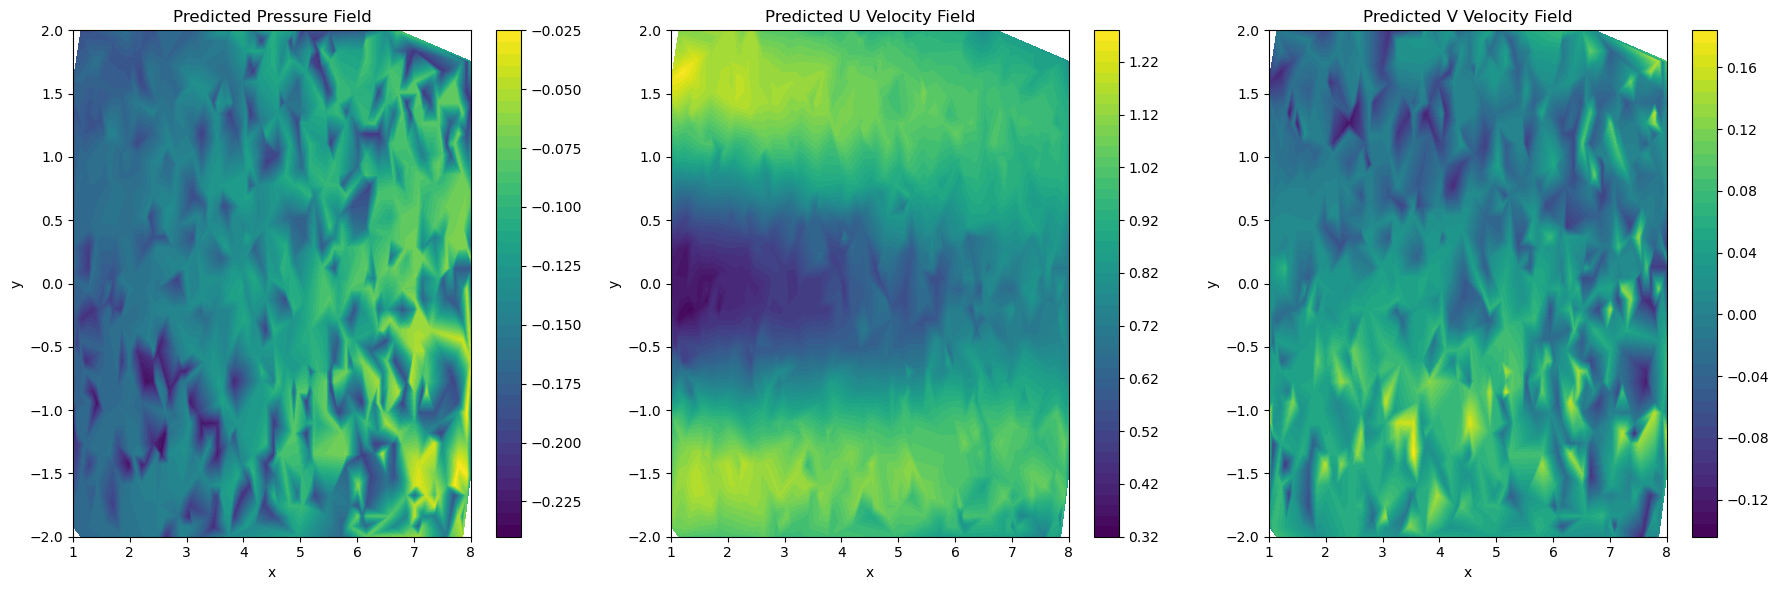

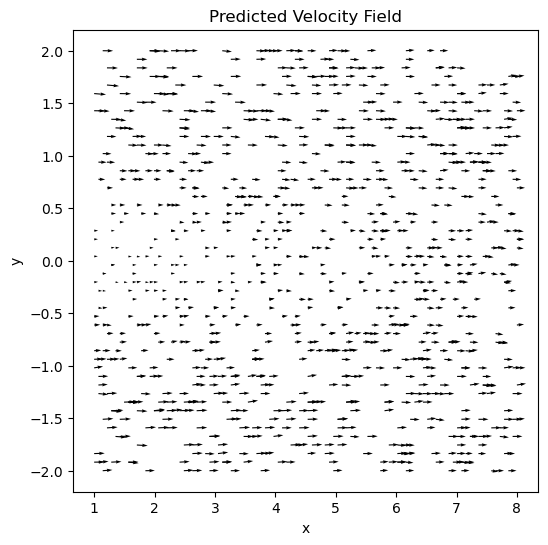

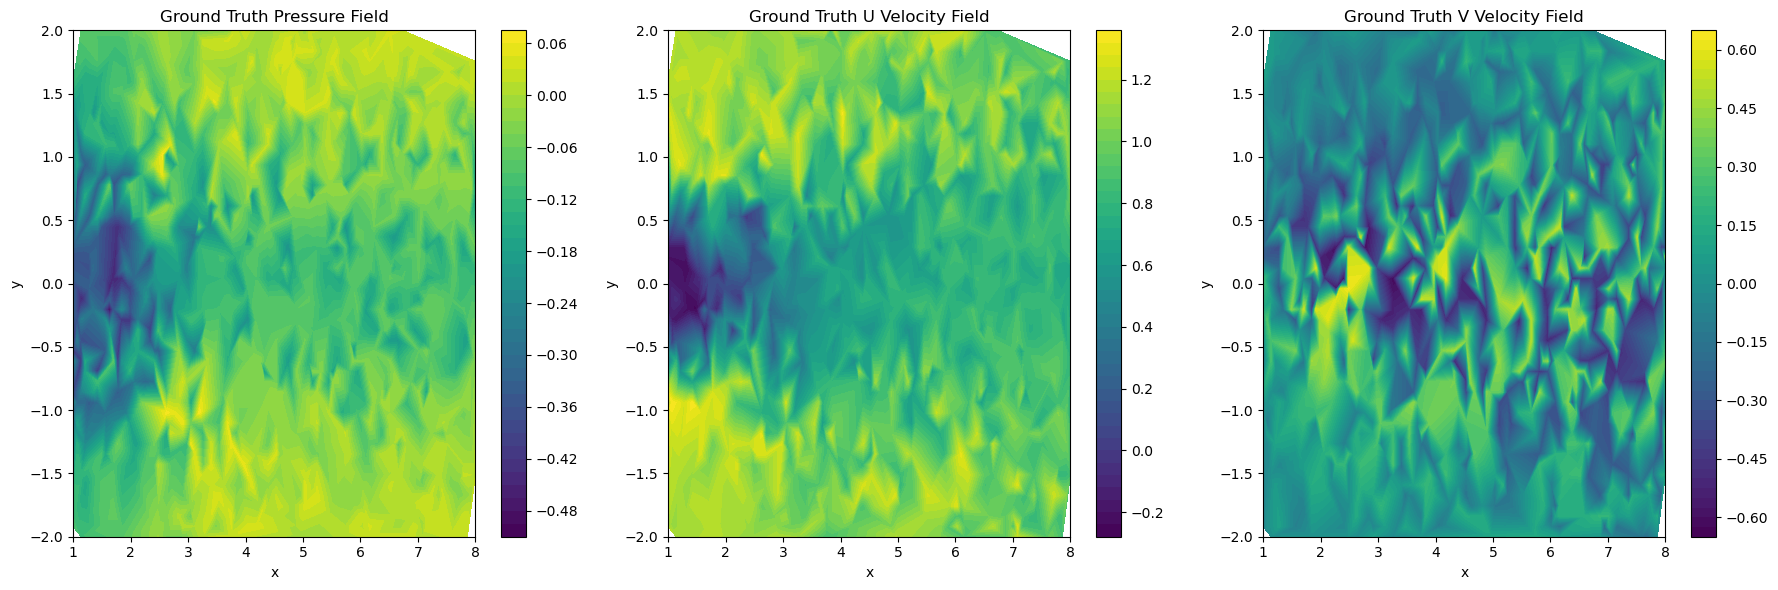

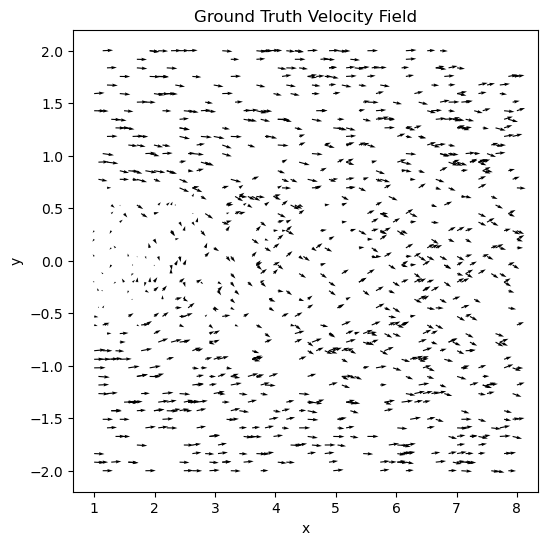

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri

# Assuming preds contains predictions in the form [p_pred, u_pred, v_pred]
# and test_arr contains the ground truth data in the form [t, x, y, p, u, v]

# Extract predictions and true values
p_pred = preds[:, 0]
u_pred = preds[:, 1]
v_pred = preds[:, 2]

# Extract true values and coordinates
x = test_arr[:, 1]
y = test_arr[:, 2]
p_true = test_arr[:, 3]
u_true = test_arr[:, 4]
v_true = test_arr[:, 5]

# Define a function to plot the results
def plot_results_preds(x, y, p_pred, u_pred, v_pred):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Create a triangulation object
    triang = tri.Triangulation(x, y)

    # Pressure field
    c1 = ax[0].tricontourf(triang, p_pred, levels=50, cmap='viridis')
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title('Predicted Pressure Field')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    # Velocity field (u component)
    c2 = ax[1].tricontourf(triang, u_pred, levels=50, cmap='viridis')
    fig.colorbar(c2, ax=ax[1])
    ax[1].set_title('Predicted U Velocity Field')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')

    # Velocity field (v component)
    c3 = ax[2].tricontourf(triang, v_pred, levels=50, cmap='viridis')
    fig.colorbar(c3, ax=ax[2])
    ax[2].set_title('Predicted V Velocity Field')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

    # Quiver plot for velocity vectors
    plt.figure(figsize=(6, 6))
    plt.quiver(x, y, u_pred, v_pred)
    plt.title('Predicted Velocity Field')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def plot_results_true(x, y, p_true, u_true, v_true):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Create a triangulation object
    triang = tri.Triangulation(x, y)

    # Pressure field
    c1 = ax[0].tricontourf(triang, p_true, levels=50, cmap='viridis')
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title('Ground Truth Pressure Field')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    # Velocity field (u component)
    c2 = ax[1].tricontourf(triang, u_true, levels=50, cmap='viridis')
    fig.colorbar(c2, ax=ax[1])
    ax[1].set_title('Ground Truth U Velocity Field')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')

    # Velocity field (v component)
    c3 = ax[2].tricontourf(triang, v_true, levels=50, cmap='viridis')
    fig.colorbar(c3, ax=ax[2])
    ax[2].set_title('Ground Truth V Velocity Field')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

    # Quiver plot for velocity vectors
    plt.figure(figsize=(6, 6))
    plt.quiver(x, y, u_true, v_true)
    plt.title('Ground Truth Velocity Field')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Call the function to plot results
plot_results_preds(x, y, p_pred, u_pred, v_pred)
plot_results_true(x, y, p_true, u_true, v_true)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from pathlib import Path
import matplotlib.tri as tri

# Extract predictions and true values
p_pred = preds[:, 0]
u_pred = preds[:, 1]
v_pred = preds[:, 2]

# Extract true values and coordinates
x = test_data[:, 1]
y = test_data[:, 2]
p_true = test_data[:, 3]
u_true = test_data[:, 4]
v_true = test_data[:, 5]

# Calculate error fields
p_error = np.abs(p_true - p_pred)
u_error = np.abs(u_true - u_pred)
v_error = np.abs(v_true - v_pred)

# Plotting function
def plot_results(x, y, field, title, cmap='viridis'):
    fig, ax = plt.subplots(figsize=(8, 6))
    triang = tri.Triangulation(x, y)
    c = ax.tricontourf(triang, field, levels=50, cmap=cmap)
    fig.colorbar(c, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

# Plot predicted fields
plot_results(x, y, p_pred, 'Predicted Pressure Field')
plot_results(x, y, u_pred, 'Predicted U Velocity Field')
plot_results(x, y, v_pred, 'Predicted V Velocity Field')

# Plot ground truth fields
plot_results(x, y, p_true, 'True Pressure Field')
plot_results(x, y, u_true, 'True U Velocity Field')
plot_results(x, y, v_true, 'True V Velocity Field')

# Plot error fields
plot_results(x, y, p_error, 'Pressure Error Field', cmap='hot')
plot_results(x, y, u_error, 'U Velocity Error Field', cmap='hot')
plot_results(x, y, v_error, 'V Velocity Error Field', cmap='hot')

# Plot vector field
def plot_vector_field(x, y, u, v, title='Velocity Field'):
    plt.figure(figsize=(8, 6))
    plt.quiver(x, y, u, v, scale=50)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

plot_vector_field(x, y, u_pred, v_pred, title='Predicted Velocity Field')
plot_vector_field(x, y, u_true, v_true, title='True Velocity Field')

# Compute and print error metrics
def compute_error_metrics(true_values, pred_values):
    return np.linalg.norm(true_values - pred_values, 2) / np.linalg.norm(true_values, 2)

err_u = compute_error_metrics(u_true, u_pred)
err_v = compute_error_metrics(v_true, v_pred)
err_p = compute_error_metrics(p_true, p_pred)

print(f"Error in U velocity: {err_u:.2e}")
print(f"Error in V velocity: {err_v:.2e}")
print(f"Error in pressure: {err_p:.2e}")


RuntimeError: Could not infer dtype of slice